In [6]:
import genderdecoder3
import re
import pandas as pd
from collections import Counter
from genderdecoder3 import assess
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import csv
from sklearn.preprocessing import MinMaxScaler

In [7]:
real_df = pd.read_csv("labelled_cleaned.csv")
real_orig_df = pd.read_csv("data_csv_format/labeled_vacancies_final.csv")
real_df["women_proportion"] = real_orig_df["women_proportion"]

In [8]:
with open('feminine_words.csv', 'r') as file:
    reader = csv.reader(file)
    feminine_coded_words = next(reader)

with open('masculine_words.csv', 'r') as file:
    reader = csv.reader(file)
    masculine_coded_words = next(reader)

In [9]:
def tfidf_bias_score(tfidf_vector, feature_names, masc_words, fem_words):
	tfidf_scores = dict(zip(feature_names, tfidf_vector.toarray()[0]))
	masc_score = sum(tfidf_scores.get(word, 0) for word in masc_words)
	fem_score = sum(tfidf_scores.get(word, 0) for word in fem_words)
	return masc_score - fem_score

def collect_partial_matches(tokens, stem_list):
	return [token for token in tokens for stem in stem_list if stem in token]

def classify_coding(masc_words, fem_words):
	if len(masc_words) > len(fem_words):
		return "masculine-coded"
	elif len(fem_words) > len(masc_words):
		return "feminine-coded"
	else:
		return "neutral"

In [16]:
def main(dataframe):
	job_descriptions = dataframe['job_description'].astype(str).tolist()
	vectorizer = TfidfVectorizer()
	tfidf_matrix = vectorizer.fit_transform(job_descriptions)
	feature_names = vectorizer.get_feature_names_out()

	bias_scores = []
	masc_words = []
	fem_words = []

	dataframe['feminine_words'] = None
	dataframe['masculine_words'] = None
	dataframe['feminine_word_count'] = 0
	dataframe['masculine_word_count'] = 0
	dataframe['score'] = 0.0
	dataframe['gender_label'] = None

	for idx, row in dataframe.iterrows():
		job_description_nl = str(row["job_description"])
		tokens = re.findall(r'\b\w+\b', job_description_nl.lower())

		fem_words = collect_partial_matches(tokens, feminine_coded_words)
		masc_words = collect_partial_matches(tokens, masculine_coded_words)
		bias_score = tfidf_bias_score(tfidf_matrix[idx], feature_names, masc_words, fem_words)

		dataframe.at[idx, "feminine_word_count"] = len(fem_words)
		dataframe.at[idx, "masculine_word_count"] = len(masc_words)
		dataframe.at[idx, "feminine_words"] = fem_words
		dataframe.at[idx, "masculine_words"] = masc_words
		dataframe.at[idx, "score"] = bias_score
		dataframe.at[idx, "gender_label"] = classify_coding(masc_words, fem_words)

	dataframe["masculine_words"] = dataframe["masculine_words"].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
	dataframe["feminine_words"] = dataframe["feminine_words"].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

	scaler = MinMaxScaler()
	label_map = {
		'masculine-coded': 1,
		'feminine-coded': -1,
		'neutral': 0
	}

	dataframe['gender_label_num'] = dataframe['gender_label'].map(label_map)
	#real_df[['bias_score_norm', 'tfidf_bias_score_norm']] = scaler.fit_transform(
	#    real_df[['score', 'gender_label_num']]
	#)
	dataframe['final_bias_score'] = (
		0.5 * dataframe['score'] + 0.5 * dataframe['gender_label_num']
	)
	return dataframe

In [15]:
new_df = pd.read_csv("data_csv_format/unlabeled_vacancies_final.csv")

In [17]:
new_df.head()
df_with_score = main(new_df)

In [20]:
df_labelled = main(real_df)
df_labelled.head()

,company_name,job_description,women_proportion,feminine_words,masculine_words,feminine_word_count,masculine_word_count,score,gender_label,gender_label_num,final_bias_score
0,ministerie van financi n: belastingdienst,tmap next foundation ervaring met projecten in...,0.40,gedetacheerd,opleidingen,1,1,-0.043281,neutral,0,-0.021640
1,belastingdienst,"- gecertificeerd scrum master, minimaal psm ii...",0.75,merendeel deels deelname,opleidingen,3,1,-0.118691,feminine-coded,-1,-0.559346
2,duo,3 jaar ervaring in het volgende eisenpakket:\n...,0.50,samendenken,competenties,1,1,-0.068705,neutral,0,-0.034353
3,dienst uitvoering onderwijs (duo),5 jaar ervaring met de volgende eisen:\n relev...,0.50,onderdeel onderwijsdeelnemers samenwerken same...,opleiding opleiding competenties analyseren an...,4,5,0.067618,masculine-coded,1,0.533809
4,asml netherlands b.v.,location: veldhoven\nnone\n company info: \n ...,0.00,,,0,0,0.000000,neutral,0,0.000000


In [18]:
df_with_score.head()

,positiontitle,job_description,feminine_words,masculine_words,feminine_word_count,masculine_word_count,score,gender_label,gender_label_num,final_bias_score
0,Freelance Technisch Consultant,Freelance technisch consultant gezocht voor ...,ondersteunt samenwerking ondersteunen,actief analyseren analyseren analyses opleidin...,3,7,0.255813,masculine-coded,1,0.627907
1,Technisch Consultant,Bulma logo Wij ontwikkelen slimme so...,verdeeld samen deel verantwoordelijkheidsgevoel,analytisch opleidingsniveau analytisch aanleiding,4,4,0.051931,neutral,0,0.025966
2,Support Engineer,Locatie Oss Synsel Techniek ...,support ondersteunen support ondersteuning beg...,analyseren_ analyseren_ opleidingsbudgetten ui...,9,5,-0.409770,feminine-coded,-1,-0.704885
3,Zelfstandig Architect,Deurne Architectenbureaus Universiteit...,onderdeel samen samenwerken samenwerken,uitdagende leiding,4,2,-0.049831,feminine-coded,-1,-0.524915
4,Java Solution Architect / Software Architect,Huidige taal Java Solution Architect / ...,ondersteunt samenwerking samen ondersteunt sam...,begeleiding analytische analytics veerkrachtige,18,4,-0.469780,feminine-coded,-1,-0.734890


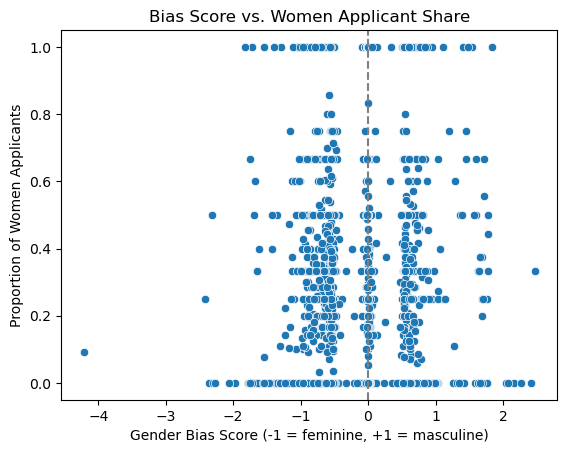

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df_labelled, x='final_bias_score', y='women_proportion')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Gender Bias Score (-1 = feminine, +1 = masculine)")
plt.ylabel("Proportion of Women Applicants")
plt.title("Bias Score vs. Women Applicant Share")
plt.show()